# Toy Example Showing Causal Injective Flow

In [1]:
%load_ext autoreload
%autoreload 2

In [18]:
import torch
import torch.nn as nn
import numpy as np

import lightning as pl
import normflows as nf
from normflows.flows.mixing import Invertible1x1Conv
from normflows.flows.affine import GlowBlock
from ciflows.glow import Injective1x1Conv, InjectiveGlowBlock, Squeeze

from torchvision.utils import make_grid, save_image
import matplotlib.pyplot as plt

## Implement an injective 1x1 convolutional layer

In this section, we will generalize the 1x1 convolutional layer introduced in the GLOW model. We will follow the steps introduced in https://arxiv.org/pdf/2102.10461.

In [3]:
batch_size, height, width, channels = 8, 28, 28, 4  # Example dimensions
activation = "linear"  # Can also test 'linear'
gamma = 1e-3

# Create an instance of Injective1x1Conv
# This will map (4, 28, 28) images to (2, 28, 28) latent space
injective_conv = Injective1x1Conv(
    num_channels_in=channels // 2, activation=activation, gamma=gamma
)

# Generate random input tensor as the "image"
x = torch.randn(batch_size, channels, height, width)

# Apply inverse pass and move images back to the latent space
v_reconstructed, log_det_inverse = injective_conv.inverse(x)

# Check shapes and log_det
print(f"Reconstructed input shape: {v_reconstructed.shape}")
print(f"Log determinant (inverse): {log_det_inverse.item()}")

# Apply forward pass
x_reconstructed, log_det_forward = injective_conv.forward(v_reconstructed)

# Check shapes and log_det
print(f"Input shape: {x.shape}")
print(f"Output shape (after forward): {x_reconstructed.shape}")
print(f"Log determinant (forward): {log_det_forward.item()}")

# Compute reconstruction error (should be close to 0)
reconstruction_error = torch.mean((x - x_reconstructed) ** 2).item()
print(f"Reconstruction error: {reconstruction_error}")

inside initialization:  Parameter containing:
tensor([[-0.7009, -0.0932],
        [-0.0932,  0.7009],
        [-0.4490,  0.5462],
        [ 0.5462,  0.4490]], requires_grad=True)
Reconstructed input shape: torch.Size([8, 2, 28, 28])
Log determinant (inverse): 0.0015888207126408815
Input shape: torch.Size([8, 4, 28, 28])
Output shape (after forward): torch.Size([8, 4, 28, 28])
Log determinant (forward): -0.0015888207126408815
Reconstruction error: 0.4943479299545288


In [90]:
batch_size, height, width, channels = 8, 32, 32, 16  # Example dimensions
gamma = 0.1

# Create an instance of Injective1x1Conv
injective_conv = Invertible1x1Conv(num_channels=channels, use_lu=False)

# Generate random input tensor
v = torch.randn(batch_size, channels, height, width)

# Apply forward pass
x, log_det_forward = injective_conv.forward(v)

# Check shapes and log_det
print(f"Input shape: {v.shape}")
print(f"Output shape (after forward): {x.shape}")
print(f"Log determinant (forward): {log_det_forward.item()}")

# Apply inverse pass
v_reconstructed, log_det_inverse = injective_conv.inverse(x)

# Check shapes and log_det
print(f"Reconstructed input shape: {v_reconstructed.shape}")
print(f"Log determinant (inverse): {log_det_inverse.item()}")

# Compute reconstruction error (should be close to 0)
reconstruction_error = torch.mean((v - v_reconstructed) ** 2).item()
print(f"Reconstruction error: {reconstruction_error}")


Input shape: torch.Size([8, 16, 32, 32])
Output shape (after forward): torch.Size([8, 16, 32, 32])
Log determinant (forward): -0.0001220703125
Reconstructed input shape: torch.Size([8, 16, 32, 32])
Log determinant (inverse): 0.0001220703125
Reconstruction error: 1.1559506065024483e-14


## Injective Glow Block

The injective Glow block is a generalization of the 1x1 convolutional layer. The injective Glow block is defined as follows:

- Activation Norm
- Injective 1x1 Convolution
- Affine coupling layer with nonlinear scaling

The injective 1x1 convolution decreases the number of channels in the input tensor.

In [91]:
from matplotlib import gridspec
import seaborn as sns


# Function to visualize input and reconstructed data side by side
def visualize_comparison(input_data, reconstructed_data, title):
    input_np = input_data.squeeze().detach().cpu().numpy()  # Convert input to numpy
    reconstructed_np = (
        reconstructed_data.squeeze().detach().cpu().numpy()
    )  # Convert reconstructed to numpy

    num_channels = input_np.shape[0]

    # Find the global min and max across both input and reconstructed data for consistent color scale
    vmin = min(input_np.min(), reconstructed_np.min())
    vmax = max(input_np.max(), reconstructed_np.max())

    fig = plt.figure(figsize=(12, 6))
    fig.suptitle(title)

    gs = gridspec.GridSpec(
        3, num_channels, height_ratios=[1, 1, 0.05]
    )  # Third row for colorbars

    for i in range(num_channels):
        # Plot input data in the first row
        ax_input = fig.add_subplot(gs[0, i])
        im = ax_input.imshow(input_np[i], cmap="gray", vmin=vmin, vmax=vmax)
        ax_input.set_title(f"Channel {i+1}")
        ax_input.set(xticks=[], yticks=[])
        if i == 0:
            ax_input.set_ylabel("Input")

        # Plot reconstructed data in the second row
        ax_reconstructed = fig.add_subplot(gs[1, i])
        ax_reconstructed.imshow(reconstructed_np[i], cmap="gray", vmin=vmin, vmax=vmax)
        # ax_reconstructed.axis('off')
        ax_reconstructed.set(xticks=[], yticks=[])
        if i == 0:
            ax_reconstructed.set_ylabel("Reconstructed")

        # Add the colorbar to a separate axes in the third row
        cbar_ax = fig.add_subplot(gs[2, i])
        fig.colorbar(im, cax=cbar_ax, orientation="horizontal")

    # plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1)
    fig.tight_layout()
    plt.show()


sns.set_context("talk", font_scale=1.1)


Check the forward pass of the injective Glow block

In [92]:
# Create sample data: a (3, 2, 2) tensor
v = torch.randn(1, 4, 2, 2)  # batch_size=1, channels=3, height=2, width=2
channels = v.shape[1]

# Initialize the InjectiveGlowBlock
glow_block = InjectiveGlowBlock(
    channels=channels, hidden_channels=100, activation="linear", scale=True,
    debug=False
)

# inverse pass to get towards the latent representation from X
output_data, log_det = glow_block.forward(v)

# Inverse pass
reconstructed_data, log_det_inv = glow_block.inverse(output_data)

reconstruction_error = torch.mean((v - reconstructed_data) ** 2).item()
print()
print('Evaluating InjectiveGlowBlock')
print(reconstruction_error)
print(v.shape, output_data.shape, reconstructed_data.shape)
print(log_det, log_det_inverse)


Evaluating InjectiveGlowBlock
1.4102399803483934e-12
torch.Size([1, 4, 2, 2]) torch.Size([1, 8, 2, 2]) torch.Size([1, 4, 2, 2])
tensor([5.5022], grad_fn=<AddBackward0>) tensor(0.0001, grad_fn=<MulBackward0>)


Traceback (most recent call last):
  File "/Users/adam2392/miniforge3/envs/ciflows/lib/python3.11/multiprocessing/queues.py", line 239, in _feed
    reader_close()
  File "/Users/adam2392/miniforge3/envs/ciflows/lib/python3.11/multiprocessing/connection.py", line 178, in close
    self._close()
  File "/Users/adam2392/miniforge3/envs/ciflows/lib/python3.11/multiprocessing/connection.py", line 377, in _close
    _close(self._handle)
OSError: [Errno 9] Bad file descriptor
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x124f5a480>
Traceback (most recent call last):
  File "/Users/adam2392/miniforge3/envs/ciflows/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1477, in __del__
    self._shutdown_workers()
  File "/Users/adam2392/miniforge3/envs/ciflows/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1441, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/Users/adam2392/miniforge3/envs/ciflows/

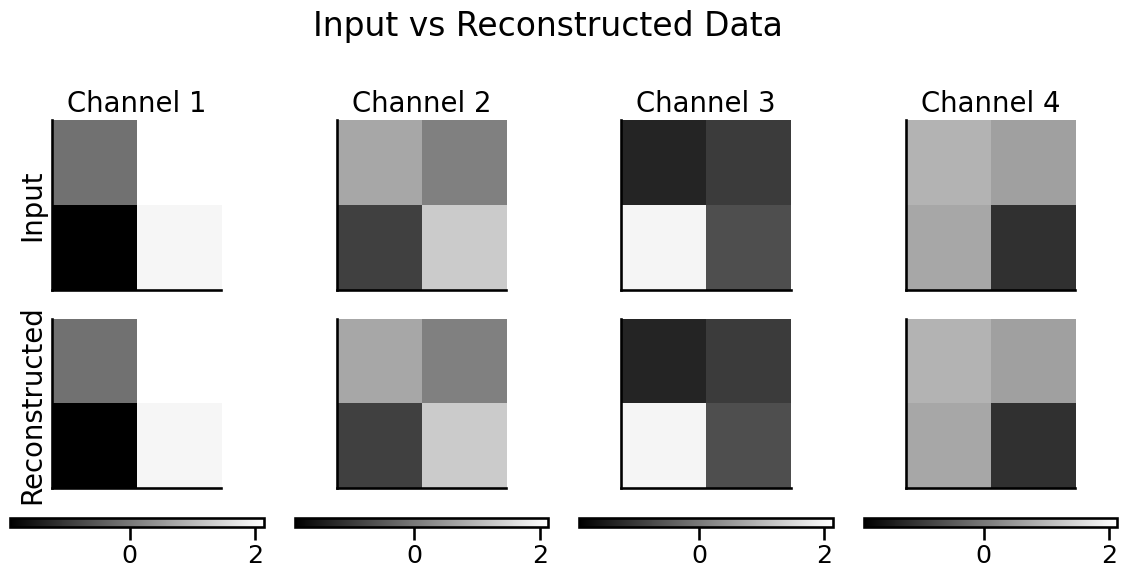

Difference between original and reconstructed: 4.7501412154815625e-06
Relative difference: 9.435454444428615e-07


In [93]:
# Visualize input and reconstructed input
visualize_comparison(v, reconstructed_data, "Input vs Reconstructed Data")

# Compute difference and norms
input_flat = v.flatten()
reconstructed_flat = reconstructed_data.flatten()

difference = torch.norm(input_flat - reconstructed_flat)
relative_difference = torch.norm(input_flat - reconstructed_flat) / torch.norm(input_flat)

print(f"Difference between original and reconstructed: {difference.item()}")
print(f"Relative difference: {relative_difference.item()}")

Check inverse pass of the injective Glow block.

In [104]:
# Create sample data: a (3, 2, 2) tensor
input_data = torch.randn(1, 4, 2, 2)  # batch_size=1, channels=3, height=2, width=2
channels = input_data.shape[1]

# Initialize the InjectiveGlowBlock
glow_block = InjectiveGlowBlock(
    channels=channels // 2, hidden_channels=100, activation="linear", scale=True,
    debug=False
)

# inverse pass to get towards the latent representation from X
output_data, log_det = glow_block.inverse(input_data)

# Inverse pass
reconstructed_data, log_det_inv = glow_block.forward(output_data)

reconstruction_error = torch.mean((input_data - reconstructed_data) ** 2).item()
print()
print('Evaluating InjectiveGlowBlock')
print(reconstruction_error)
print(input_data.shape, output_data.shape, reconstructed_data.shape)
print(log_det, log_det_inverse)


Evaluating InjectiveGlowBlock
0.34626516699790955
torch.Size([1, 4, 2, 2]) torch.Size([1, 2, 2, 2]) torch.Size([1, 4, 2, 2])
tensor([4.6240], grad_fn=<AddBackward0>) tensor(0.0015, grad_fn=<MulBackward0>)


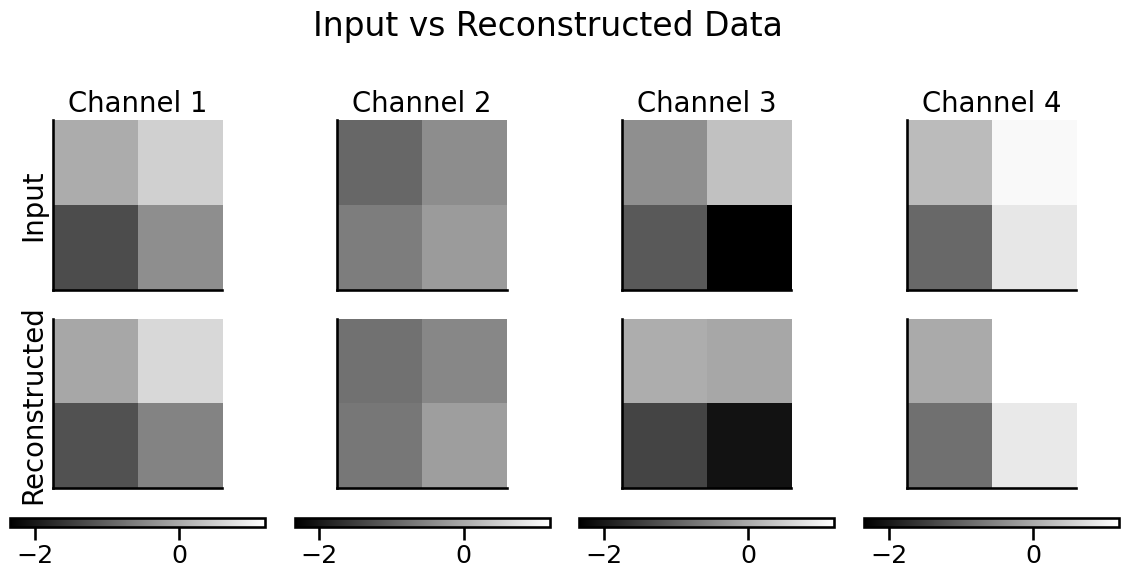

In [ ]:

sns.set_context("talk", font_scale=1.1)

# Visualize input and reconstructed input
visualize_comparison(input_data, reconstructed_data, "Input vs Reconstructed Data")

Check regular invertible Glow Block model, which will be stable in both the forward and inverse pass.

In [111]:
# Create sample data: a (3, 2, 2) tensor
input_data = torch.randn(1, 4, 2, 2)  # batch_size=1, channels=3, height=2, width=2

# Initialize the InjectiveGlowBlock
glow_block = GlowBlock(
    channels=4, hidden_channels=4, use_lu=False, scale=True
)

# Forward pass
output_data, log_det = glow_block.inverse(input_data)

# Inverse pass
reconstructed_data, log_det_inv = glow_block.forward(output_data)

print(input_data.shape, output_data.shape, reconstructed_data.shape)
print(log_det, log_det_inverse)

torch.Size([1, 4, 2, 2]) torch.Size([1, 4, 2, 2]) torch.Size([1, 4, 2, 2])
tensor([-0.9503], grad_fn=<AddBackward0>) tensor(0.0015, grad_fn=<MulBackward0>)


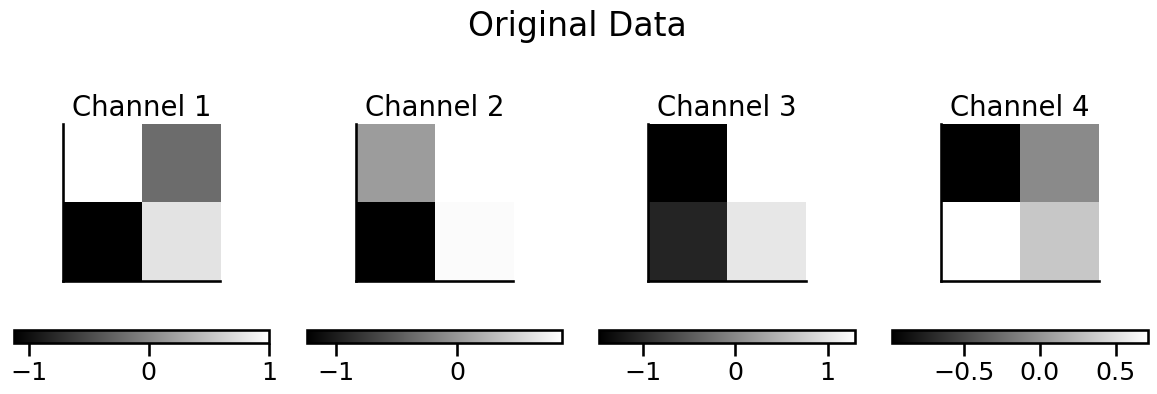

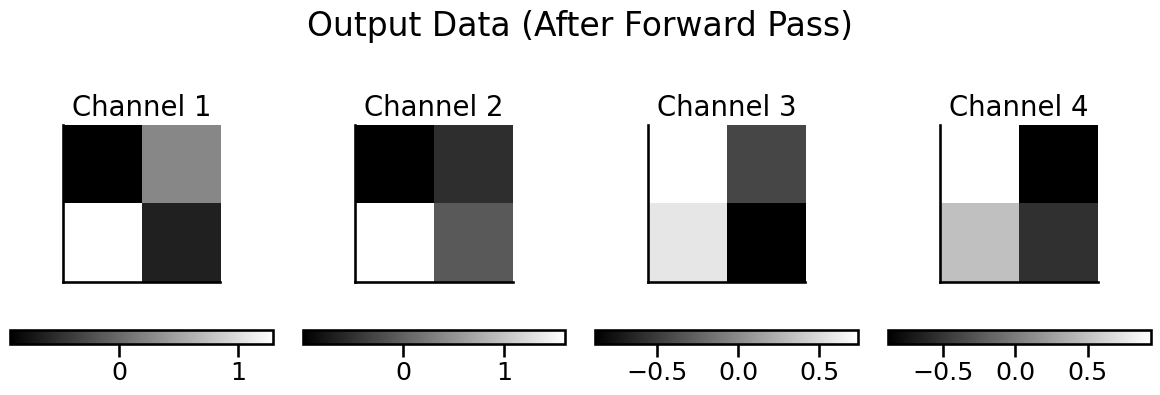

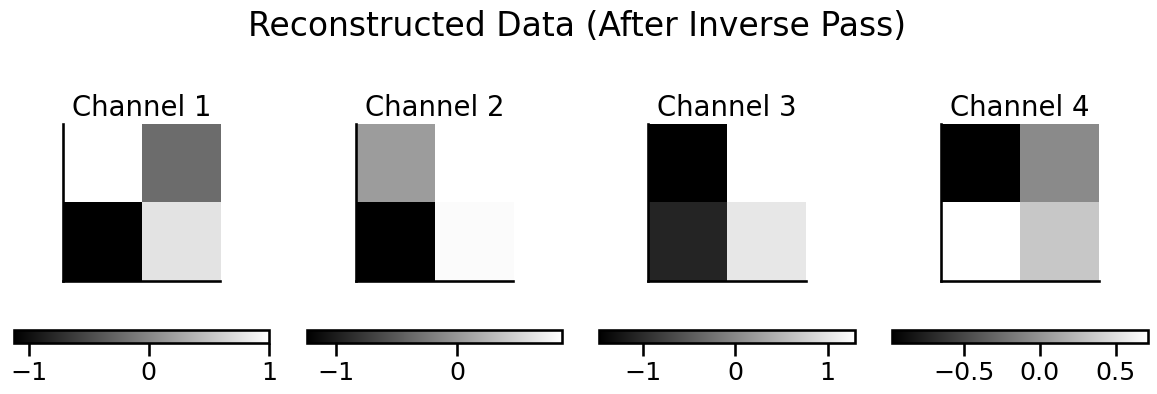

Difference between original and reconstructed: 2.0271193079679506e-07
Relative difference: 5.523397561546517e-08


In [112]:



# Visualizing before and after
def visualize_data(data, title):
    data_np = data.squeeze().detach().cpu().numpy()  # Convert to numpy for plotting
    fig, axs = plt.subplots(1, data_np.shape[0], figsize=(12, 4))
    fig.suptitle(title)
    for i in range(data_np.shape[0]):
        im = axs[i].imshow(data_np[i], 
                        #    vmin=-2, vmax=2,
                           cmap='gray')
        axs[i].set_title(f"Channel {i+1}")
        axs[i].set(xticks=[], yticks=[])
        cbar = fig.colorbar(im, ax=axs[i], orientation='horizontal', pad=0.2)  # Colorbar at the bottom

    # divider = make_axes_locatable(axs[i])
    # cax = divider.append_axes('right', size='5%', pad=0.05)
    # fig.colorbar(im, cax=cax, orientation='vertical')
    plt.show()

# Visualize original data
visualize_data(input_data, "Original Data")

# Visualize data after forward pass and inverse pass
visualize_data(output_data, "Output Data (After Forward Pass)")
visualize_data(reconstructed_data, "Reconstructed Data (After Inverse Pass)")

# Numerical comparisons
input_flat = input_data.flatten()
reconstructed_flat = reconstructed_data.flatten()

# Compute difference and norms
difference = torch.norm(input_flat - reconstructed_flat)
relative_difference = torch.norm(input_flat - reconstructed_flat) / torch.norm(input_flat)

print(f"Difference between original and reconstructed: {difference.item()}")
print(f"Relative difference: {relative_difference.item()}")

## Injective flow model

Now, we can put these along with the Glow blocks to create an injective flow, similar to that in https://arxiv.org/pdf/2102.10461. Our goal is to create a toy example to show the injective flow works with a "lower dimensional" multivariate independent Gaussian prior.

The flow model is defined loosely as follows starting from the latent variable representation:

First, we apply various bijective glow blocks to allow for proper mixing:

1. bijective glow block (C, H, W) -> (C, H, W)
2. upsqueeze (C, H, W) -> (C * 4, H // 2, W // 2)

Then, we apply a sequence of bijective, injective, upsqueeze layers:

1. bijective glow block (C, H, W) -> (C, H, W)
2. injective glow block (C, H, W) -> (C/2, H, W)
3. upsqueeze (C/2, H, W) -> (C * 2^2, H // 2, W // 2)

These three blocks are repeated multiple times to create a flow model for n_layers.
The final output is 1 / 2^{n_layers} of the original input size where the decrease comes at the channels.

Next steps:

1. Multi-scale architecture, where we interchange squeeze and merge operations to create a multi-scale architecture.
2. We will add a causal prior.

In [131]:
n_hidden = 32
n_mixing_layers = 2
n_injective_layers = 3
n_glow_blocks = 2

activation = 'linear'
input_shape = (1, 28, 28)
n_channels = input_shape[0]

n_chs = n_channels
flows = []

debug = False

# add the initial mixing layers
print('Beginning of mixing flows.')
mixing_flows = []
# Add flow layers starting from the latent representation
for i in range(n_mixing_layers):
    # n_chs = C * 4^(L - i)
    n_chs = n_channels * 4 ** (n_mixing_layers - i)
    
    if debug:
        print(f'On layer {n_mixing_layers - i}, n_chs = {n_chs}')
    for j in range(n_glow_blocks):
        mixing_flows += [
            GlowBlock(
                channels=n_chs,
                hidden_channels=n_hidden,
                use_lu=False,
                scale=True,
            )
        ]
    mixing_flows += [Squeeze()]

# reverse the mixing flows to go from X -> V.
mixing_flows = mixing_flows[::-1]
i = 1
for flow in mixing_flows:
    if hasattr(flow, 'n_channels'):
        print(f'On layer {i}, n_chs = {flow.n_channels}')
        i += 1
num_layers = i

print('Beginning of injective flows.')
n_chs = n_channels * 4 ** (n_mixing_layers - 0)
debug = True
# add injective blocks
injective_flows = []
for i in range(n_injective_layers):
    # Note: this is adding from V -> X
    n_chs = n_chs // 2
    injective_flows += [
        InjectiveGlowBlock(
        channels=n_chs,
        hidden_channels=n_hidden,
        activation=activation,
        scale=True,
    )
    ]

    if debug:
        print(f'On layer {i + num_layers}, n_chs = {n_chs}')
    for j in range(n_glow_blocks):
        injective_flows += [
            GlowBlock(
                channels=n_chs,
                hidden_channels=n_hidden,
                use_lu=False,
                scale=True,
            )
        ]

# Note: this is constructed as X -> V, so we need to reverse the flows
# to adhere to the normflows convention of V -> X
flows = mixing_flows
flows.extend(injective_flows)
flows = flows[::-1]

# # q0 = nf.distributions.DiagGaussian((n_channels, 32, 32))

Beginning of mixing flows.
On layer 1, n_chs = 4
On layer 2, n_chs = 4
On layer 3, n_chs = 16
On layer 4, n_chs = 16
Beginning of injective flows.
inside initialization:  Parameter containing:
tensor([[-6.2070e-02,  1.9531e-01,  3.5248e-01, -4.7862e-02, -3.5823e-01,
          7.1739e-02,  2.8358e-04, -4.4496e-01],
        [ 8.7660e-04, -2.4927e-02,  2.2045e-01, -2.7919e-01, -3.2842e-01,
         -7.6549e-02,  2.4567e-01,  4.4582e-01],
        [ 2.1920e-02, -2.0508e-01, -4.2776e-01, -1.7760e-01, -1.9803e-01,
          1.5058e-01,  3.5869e-01, -2.2889e-01],
        [ 2.2128e-01, -2.5868e-01,  8.5229e-02, -2.4034e-01, -2.7337e-02,
          4.3921e-01, -3.5174e-01,  4.1551e-02],
        [ 3.0121e-01,  5.3388e-01, -1.0132e-01, -2.3589e-01,  1.6790e-01,
          1.4051e-01,  9.8848e-02,  2.4979e-02],
        [-2.5651e-01,  2.1365e-01, -3.4217e-01, -1.1214e-01, -2.9652e-01,
         -8.2676e-02, -3.9367e-01,  9.5720e-02],
        [ 4.1944e-01,  3.7796e-02, -9.6957e-02,  4.4064e-01, -3.2822e

In [132]:
print()
print('Debugging the flow model inverse sqeuence: ')
batch_size = 2
output, ldj = torch.randn(batch_size, 1, 28, 28), 0
x = output
# output
for idx, flow in enumerate(flows[::-1]):
    # try:
    #     print(flow.batch_dims, flow.n_dim, flow.s.shape)
    # except Exception as e:
    #     print(idx)
    output, ldj = flow.inverse(output)
    # print(ldj)
    print("Running: ", idx, type(flow), output.shape)

v = output

for idx, flow in enumerate(flows):
    # try:
    #     print(flow.batch_dims, flow.n_dim, flow.s.shape)
    # except Exception as e:
    #     print(idx)
    output, ldj = flow.forward(output)
    # print(ldj)
    print("Running: ", idx, type(flow), output.shape)

x_reconstructed = output

reconstruction_error = torch.mean((x - x_reconstructed) ** 2).item()
print()
print('Evaluating InjectiveGlowBlock')
print(reconstruction_error)
print(v.shape, x.shape, x_reconstructed.shape)


Debugging the flow model inverse sqeuence: 
Running:  0 <class 'ciflows.glow.Squeeze'> torch.Size([2, 4, 14, 14])
Running:  1 <class 'normflows.flows.affine.glow.GlowBlock'> torch.Size([2, 4, 14, 14])
Running:  2 <class 'normflows.flows.affine.glow.GlowBlock'> torch.Size([2, 4, 14, 14])
Running:  3 <class 'ciflows.glow.Squeeze'> torch.Size([2, 16, 7, 7])
Running:  4 <class 'normflows.flows.affine.glow.GlowBlock'> torch.Size([2, 16, 7, 7])
Running:  5 <class 'normflows.flows.affine.glow.GlowBlock'> torch.Size([2, 16, 7, 7])
Running:  6 <class 'ciflows.glow.InjectiveGlowBlock'> torch.Size([2, 8, 7, 7])
Running:  7 <class 'normflows.flows.affine.glow.GlowBlock'> torch.Size([2, 8, 7, 7])
Running:  8 <class 'normflows.flows.affine.glow.GlowBlock'> torch.Size([2, 8, 7, 7])
Running:  9 <class 'ciflows.glow.InjectiveGlowBlock'> torch.Size([2, 4, 7, 7])
Running:  10 <class 'normflows.flows.affine.glow.GlowBlock'> torch.Size([2, 4, 7, 7])
Running:  11 <class 'normflows.flows.affine.glow.GlowBlo

In [51]:
print()
print('Debugging the flow model forward sqeuence: ')
batch_size = 2
v_latent, ldj = torch.randn(batch_size, 6, 7, 7), 0
output = v_latent
for idx, flow in enumerate(flows):
    # try:
    #     print(flow.batch_dims, flow.n_dim, flow.s.shape)
    # except Exception as e:
    #     print(idx)
    output, ldj = flow.forward(output)
    # print(ldj)
    print("Running: ", idx, type(flow), output.shape)

x = output

for idx, flow in enumerate(flows[::-1]):
    # try:
    #     print(flow.batch_dims, flow.n_dim, flow.s.shape)
    # except Exception as e:
    #     print(idx)
    output, ldj = flow.inverse(output)
    # print(ldj)
    print("Running: ", idx, type(flow), output.shape)

reconstructed_v = output

reconstruction_error = torch.mean((v_latent - reconstructed_v) ** 2).item()
print()
print('Evaluating InjectiveGlowBlock')
print(reconstruction_error)
print(v_latent.shape, x.shape, reconstructed_v.shape)


Debugging the flow model forward sqeuence: 
Running:  0 <class 'normflows.flows.affine.glow.GlowBlock'> torch.Size([2, 6, 7, 7])
Running:  1 <class 'normflows.flows.affine.glow.GlowBlock'> torch.Size([2, 6, 7, 7])
Running:  2 <class 'ciflows.glow.InjectiveGlowBlock'> torch.Size([2, 12, 7, 7])
Running:  3 <class 'normflows.flows.affine.glow.GlowBlock'> torch.Size([2, 12, 7, 7])
Running:  4 <class 'normflows.flows.affine.glow.GlowBlock'> torch.Size([2, 12, 7, 7])
Running:  5 <class 'ciflows.glow.InjectiveGlowBlock'> torch.Size([2, 24, 7, 7])
Running:  6 <class 'normflows.flows.affine.glow.GlowBlock'> torch.Size([2, 24, 7, 7])
Running:  7 <class 'normflows.flows.affine.glow.GlowBlock'> torch.Size([2, 24, 7, 7])
Running:  8 <class 'ciflows.glow.InjectiveGlowBlock'> torch.Size([2, 48, 7, 7])
Running:  9 <class 'normflows.flows.affine.glow.GlowBlock'> torch.Size([2, 48, 7, 7])
Running:  10 <class 'normflows.flows.affine.glow.GlowBlock'> torch.Size([2, 48, 7, 7])
Running:  11 <class 'ciflows

# Training an injective flow model on now toy dataset

In [4]:
from tqdm import tqdm
import torch

import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Sampler

# Set random seed for reproducibility
torch.manual_seed(0)

# Load MNIST dataset
transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,)),
    ]
)
root = "../data"
train_dataset = datasets.MNIST(
    root=root, train=True, download=True, transform=transform
)
test_dataset = datasets.MNIST(
    root=root, train=False, download=True, transform=transform
)

In [5]:
# create a Sampler to ensure that each batch contains every digit
labels = train_dataset.targets
# Custom Stratified Sampler
class StratifiedSampler(Sampler):
    def __init__(self, labels, batch_size, seed=None):
        self.labels = labels
        self.batch_size = batch_size
        self.seed = seed
        self.num_samples = len(labels)
        self.unique_labels = np.unique(labels)
        self.label_indices = {label: np.where(labels == label)[0] for label in self.unique_labels}
        self.indices = self._generate_indices()

    def _generate_indices(self):
        indices = []
        num_per_class = self.batch_size // len(self.unique_labels)

        rng = np.random.default_rng(self.seed)
        for _ in range(self.num_samples // self.batch_size):
            batch_indices = []
            for label in self.unique_labels:
                label_indices = rng.choice(
                    self.label_indices[label], num_per_class, replace=False
                )
                batch_indices.extend(label_indices)

            rng.shuffle(batch_indices)
            indices.extend(batch_indices)

        return indices

    def __iter__(self):
        return iter(self.indices)

    def __len__(self):
        return self.num_samples

In [24]:
n_hidden = 64
n_mixing_layers = 2
n_injective_layers = 3
n_glow_blocks = 2
use_lu = True
gamma = 1e-2
activation = "relu"

input_shape = (1, 28, 28)
n_channels = input_shape[0]

n_chs = n_channels
flows = []

debug = False

# add the initial mixing layers
print("Beginning of mixing flows.")
mixing_flows = []
# Add flow layers starting from the latent representation
for i in range(n_mixing_layers):
    # n_chs = C * 4^(L - i)
    n_chs = n_channels * 4 ** (n_mixing_layers - i)

    if debug:
        print(f"On layer {n_mixing_layers - i}, n_chs = {n_chs}")
    for j in range(n_glow_blocks):
        mixing_flows += [
            GlowBlock(
                channels=n_chs,
                hidden_channels=n_hidden,
                use_lu=use_lu,
                scale=True,
            )
        ]
    mixing_flows += [Squeeze()]

# reverse the mixing flows to go from X -> V.
mixing_flows = mixing_flows[::-1]
i = 1
for flow in mixing_flows:
    if hasattr(flow, "n_channels"):
        print(f"On layer {i}, n_chs = {flow.n_channels}")
        i += 1
num_layers = i

print("Beginning of injective flows.")
n_chs = n_channels * 4 ** (n_mixing_layers - 0)
debug = True
# add injective blocks
injective_flows = []
for i in range(n_injective_layers):
    # Note: this is adding from V -> X
    n_chs = n_chs // 2
    injective_flows += [
        InjectiveGlowBlock(
            channels=n_chs,
            hidden_channels=n_hidden,
            activation=activation,
            scale=True,
        )
    ]

    if debug:
        print(f"On layer {i + num_layers}, n_chs = {n_chs}")
    for j in range(n_glow_blocks):
        injective_flows += [
            GlowBlock(
                channels=n_chs,
                hidden_channels=n_hidden,
                use_lu=use_lu,
                scale=True,
            )
        ]

# Note: this is constructed as X -> V, so we need to reverse the flows
# to adhere to the normflows convention of V -> X
flows = mixing_flows
flows.extend(injective_flows)
flows = flows[::-1]

print('n_channels: ', n_chs)
q0 = nf.distributions.DiagGaussian((n_chs, 7, 7))

model = nf.NormalizingFlow(q0=q0, flows=flows)

pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(pytorch_total_params)

Beginning of mixing flows.
On layer 1, n_chs = 4
On layer 2, n_chs = 4
On layer 3, n_chs = 16
On layer 4, n_chs = 16
Beginning of injective flows.
On layer 5, n_chs = 8
On layer 6, n_chs = 4
On layer 7, n_chs = 2
n_channels:  2
127806


In [25]:
def initialize_flow(model):
    """
    Initialize a full normalizing flow model
    """
    for name, param in model.named_parameters():
        if 'weight' in name:
            # Layer-dependent initialization
            if 'coupling' in name:
                nn.init.normal_(param, mean=0.0, std=0.01)
            else:
                nn.init.xavier_uniform_(param)
        elif 'bias' in name:
            nn.init.constant_(param, 0.0)

initialize_flow(model)

In [26]:
for flow in model.flows:
    if hasattr(flow, "flows") and 'Injective' in flow.__class__.__name__:
        for flow_ in flow.flows:
            if hasattr(flow_, 'W'):
                print(flow_.W)
            # print(flow_)

Parameter containing:
tensor([[-0.1244,  0.9922],
        [ 0.9922,  0.1244]], requires_grad=True)
Parameter containing:
tensor([[-0.9661,  0.2040,  0.1577, -0.0074],
        [-0.2261, -0.4511, -0.8150, -0.2849],
        [ 0.1000,  0.8599, -0.5005, -0.0088],
        [-0.0737, -0.1246, -0.2456,  0.9585]], requires_grad=True)
Parameter containing:
tensor([[-0.3819,  0.3274, -0.4654,  0.0391,  0.4602,  0.0257, -0.5400, -0.1570],
        [-0.3719, -0.0885,  0.2409, -0.5802, -0.4980,  0.1259, -0.4335, -0.0863],
        [-0.4719, -0.4068, -0.3121, -0.1611,  0.0251, -0.4340,  0.4398, -0.3256],
        [ 0.2990,  0.4860,  0.2719, -0.2366,  0.0707, -0.3243,  0.0672, -0.6557],
        [-0.4457,  0.1811,  0.2369,  0.4586, -0.1502,  0.5160,  0.2613, -0.3808],
        [-0.4382,  0.4567,  0.3434,  0.0698,  0.0092, -0.4582,  0.1373,  0.4976],
        [ 0.0263, -0.2980,  0.1850,  0.5920, -0.2316, -0.4534, -0.4780, -0.1954],
        [ 0.1115,  0.3913, -0.5879,  0.1194, -0.6770, -0.0907,  0.0826,  0.034

In [27]:
@torch.no_grad()
def evaluate_loss(model, data_loader, device):
    """
    Evaluate the loss on the given data loader
    """
    model.eval()
    total_loss = 0.0
    for x, _ in data_loader:
        x = x.to(device)
        loss = model.forward_kld(x).mean()
        total_loss += loss
    model.train()
    return total_loss / len(data_loader.dataset)


In [28]:
num_workers = 4
# Create DataLoader with the custom StratifiedSampler
# ensuring that each batch contains every digit
sampler = StratifiedSampler(labels, batch_size, seed=1234)
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    #   sampler=sampler
)

val_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
)

In [30]:
lr = 1e-5
batch_size = 64
num_workers = 4
n_iters = 2
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

device = 'cpu'
print(f"Using device: {device}")
m = model.to(device)

optimizer = optim.Adam(model.parameters(), lr=lr)

for iter in tqdm(range(n_iters)):
    model.train()

    total_loss = 0
    
    for flow in model.flows:
        if hasattr(flow, "flows") and 'Injective' in flow.__class__.__name__:
            for flow_ in flow.flows:
                if hasattr(flow_, 'W'):
                    print(flow_.W)
                # print(flow_)
    for batch_idx, (x, _) in enumerate(train_loader):
        x = x.to(device)

        optimizer.zero_grad()

        # get the negative log likelihood
        loss = model.forward_kld(x).mean()
        if batch_idx % 10 == 0:
            # evaluate the loss on a validation dataset
            val_loss = evaluate_loss(model, val_loader, device)

            print(f'Batch {batch_idx}: Training Loss = {loss.item()}')
            print(f'Validation Loss = {val_loss.item()}')
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        # break
    # break

    if iter % 10 == 0:
        print(f"Iteration {iter}: Loss = {total_loss / len(train_loader)}")

Using device: cpu


  0%|          | 0/2 [00:00<?, ?it/s]

Parameter containing:
tensor([[-0.1244,  0.9922],
        [ 0.9922,  0.1244]], requires_grad=True)
Parameter containing:
tensor([[-0.9661,  0.2040,  0.1577, -0.0074],
        [-0.2261, -0.4511, -0.8150, -0.2849],
        [ 0.1000,  0.8599, -0.5005, -0.0088],
        [-0.0737, -0.1246, -0.2456,  0.9585]], requires_grad=True)
Parameter containing:
tensor([[-0.3819,  0.3274, -0.4654,  0.0391,  0.4602,  0.0257, -0.5400, -0.1570],
        [-0.3719, -0.0885,  0.2409, -0.5802, -0.4980,  0.1259, -0.4335, -0.0863],
        [-0.4719, -0.4068, -0.3121, -0.1611,  0.0251, -0.4340,  0.4398, -0.3256],
        [ 0.2990,  0.4860,  0.2719, -0.2366,  0.0707, -0.3243,  0.0672, -0.6557],
        [-0.4457,  0.1811,  0.2369,  0.4586, -0.1502,  0.5160,  0.2613, -0.3808],
        [-0.4382,  0.4567,  0.3434,  0.0698,  0.0092, -0.4582,  0.1373,  0.4976],
        [ 0.0263, -0.2980,  0.1850,  0.5920, -0.2316, -0.4534, -0.4780, -0.1954],
        [ 0.1115,  0.3913, -0.5879,  0.1194, -0.6770, -0.0907,  0.0826,  0.034

  0%|          | 0/2 [02:30<?, ?it/s]


KeyboardInterrupt: 

torch.Size([3, 122, 122])


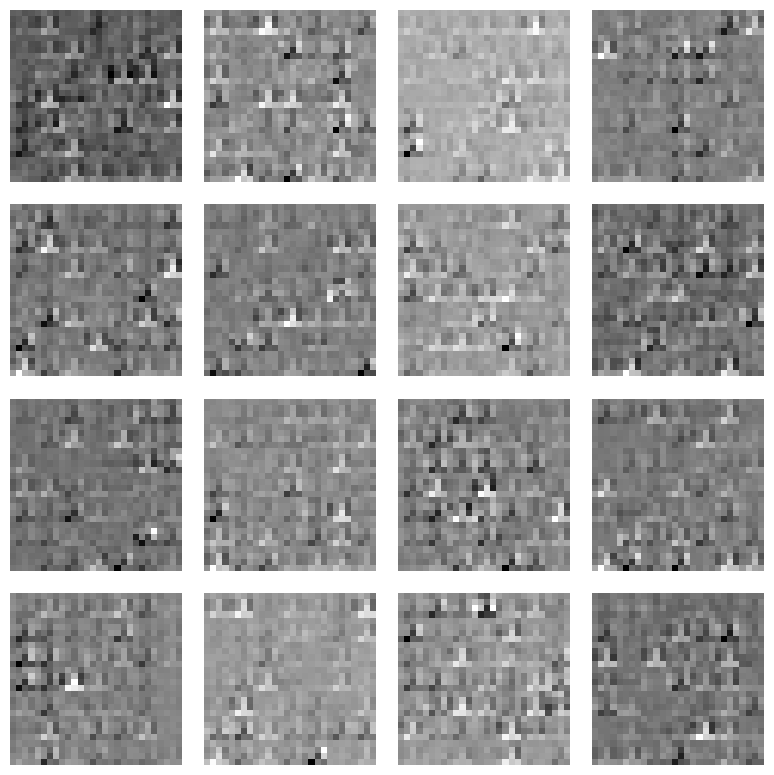

In [31]:
# Step 7: Evaluation
# model.eval()  # Set model to evaluation mode
# with torch.no_grad():
#     loss = evaluate_loss(model, val_loader, device) # Compute loss
#     avg_test_loss = loss.item()  # Accumulate test loss

# print(f'Test Loss: {avg_test_loss:.4f}')

# Step 8: Generate Samples
num_samples = 16
model.eval()
model = model.to(torch.device('cpu'))
with torch.no_grad():
    samples, _ = model.sample(num_samples)  # Generate samples
    samples = samples.view(-1, 1, 28, 28).cpu()  # Reshape for plotting

# Visualize generated samples

# Visualize generated samples
grid_size = make_grid(samples, nrow=4, padding=2)
save_image(grid_size, 'generated_samples.png', normalize=True)

print(grid_size.shape)
fig, axes = plt.subplots(4, 4, figsize=(8, 8))
for i in range(num_samples):
    ax = axes[i // 4, i % 4]
    ax.imshow(samples[i].squeeze(), cmap='gray')
    ax.axis('off')
plt.show()

## Implement generalized injective flow model

In https://arxiv.org/pdf/2306.01843, the authors introduce an approximate injective flow model, which allows an arbitrary neural network architecture to be approximately injective. 

The model is defined with an arbitrary architecture that consists of a:

- encoder: $f(x) : \mathbb{R}^d \rightarrow \mathbb{R}^m$
- decoder: $g(v) : \mathbb{R}^m \rightarrow \mathbb{R}^d$

where $d$ is the dimension of the input and $m$ is the dimension of the latent space. The model imposes a probabilistic representation layer in the middle that defines a distribution $p(v)$ over the latent space. The encoder and decoder are trained to minimize the following loss function:

Negative Log-likelihood + Volume-Preserving Loss + Regularization Loss

- Negative log-likelihood: $L(x) = -\log p_v(f(x))$
- Volume-Preserving Loss: $L_{\text{vp}}(x) = \log \left| \det \left( \nabla_{f}(f(x))^T \nabla_{f}(f(x)) \right)^{-1/2} \right|$
- Regularization Loss: $L_{\text{reg}}(x) = \beta ||x - \hat{x}||^2$

These losses combine to ensure the final model can reconstruct the input data, maximizes the likelihood, while accounting for volume changes when mapping data across different functions. 

In [ ]:
from typing import Any


class InjectiveFlowModel(pl.LightningModule):
    def __init__(self, *args: Any, **kwargs: Any) -> None:
        super().__init__(*args, **kwargs)
        # define the flows that comprise a sequence of GLOW blocks

        # define the final prior causal distribution


    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return x
    
    def training_step(self, batch, batch_idx):
        x, _ = batch
        return x
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer

In [ ]:
merges = []
flows = []
n_layers = 3
n_blocks = 2

for i in range(n_layers):
    flows_ = []
    for j in range(n_blocks):
        n_chs = channels * 2 ** (n_layers + 1 - i)
        flows_ += [
            
        ]

In [ ]:
# implement network

class InjectiveModel(nn.Module):
    def __init__(self, input_dim, n_blocks, hidden_dim, output_dim):
        super(InjectiveModel, self).__init__()
        
        # number of injective blocks
        # each block consists of a recurring set of layers
        self.n_blocks = n_blocks

        # squeeze layer
        self.squeeze = nf.flows.Squeeze()

        # define the bijective flows

        # define the injective flows


